# MTA Project:  Work-From-Home Trends


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [7]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd

#Connect notebook to the `mta_data.db` database, in which we've put 
#MTA turnstile data from the months 4/19, 5/19, 4/21, and 5/21

engine = create_engine("sqlite:///mta_data.db")

df = pd.read_sql('SELECT * FROM mta_data;', engine)
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,00:00:00,REGULAR,7575503,2588978
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,04:00:00,RECOVR AUD,7575515,2588982
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,08:00:00,REGULAR,7575523,2588989
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,12:00:00,REGULAR,7575557,2588996
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,16:00:00,REGULAR,7575630,2589008


SQL query interlude:

In [10]:
testquery = '''
SELECT * FROM mta_data m 
WHERE m.DESC='REGULAR'
GROUP BY STATION
HAVING DATE LIKE '%/22/2021'
'''

testdata = pd.read_sql(testquery, engine)
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   C/A       378 non-null    object
 1   UNIT      378 non-null    object
 2   SCP       378 non-null    object
 3   STATION   378 non-null    object
 4   LINENAME  378 non-null    object
 5   DIVISION  378 non-null    object
 6   DATE      378 non-null    object
 7   TIME      378 non-null    object
 8   DESC      378 non-null    object
 9   ENTRIES   378 non-null    int64 
 10  EXITS     378 non-null    int64 
dtypes: int64(2), object(9)
memory usage: 32.6+ KB


Clean up columns

In [13]:
df.columns =  df.columns.str.strip()

import datetime
df["DT"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

#Unique Turnstile ID
df['TURNID'] = df['C/A'] + df['UNIT'] + df['SCP'] + df['STATION']

#Remove unnecessary columns
del df['C/A']
del df['UNIT']
del df['SCP']
del df['DIVISION']

df[["PREV_ENTRIES", "PREV_EXITS"]] = df[["ENTRIES", "EXITS"]].shift(1)
df.reset_index(drop=True, inplace=True)

In [22]:
# Examine duplicates
df[df.duplicated(subset=['TURNID','DT'], keep=False)]
df_copy = df.copy()

# Looks like we can safely drop them
df.drop_duplicates(subset=["TURNID", "DT"], inplace=True)

In [24]:
# Make Net entries and exits column
df["NETENTRIES"] = df["ENTRIES"] - df["PREV_ENTRIES"]
df["NETEXITS"] = df["EXITS"] - df["PREV_EXITS"]
# df.head()

# drop first row of each turnstile since the netentries are nonsense
mask = (df['TURNID'] != df['TURNID'].shift(1))
df.drop(df[mask].index, inplace = True)
# df.shape

Go from cumulative counts to net counts, with some additional cleaning:

In [25]:
def get_net_entries(row, max_counter):
    entrycounter = row["NETENTRIES"]
    exitcounter = row["NETEXITS"]
      
    if entrycounter < 0:
        entrycounter = -entrycounter  # adjust for "reverse" counter
    if exitcounter < 0:
        exitcounter = -exitcounter  # adjust for "reverse" counter
        
    if entrycounter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        # print(f'entries: {row["ENTRIES"]}, prev_entries: {row["PREV_ENTRIES"]}')
        entrycounter = min(row["ENTRIES"], row["PREV_ENTRIES"])

    if exitcounter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        # print(f'exits: {row["EXITS"]}, prev_exits: {row["PREV_EXITS"]}')
        exitcounter = min(row["EXITS"], row["PREV_EXITS"])

    if entrycounter > max_counter or exitcounter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
        
    return entrycounter

def get_net_exits(row, max_counter):
    entrycounter = row["NETENTRIES"]
    exitcounter = row["NETEXITS"]
      
    if entrycounter < 0:
        entrycounter = -entrycounter  # adjust for "reverse" counter
    if exitcounter < 0:
        exitcounter = -exitcounter  # adjust for "reverse" counter
        
    if entrycounter > max_counter:
        ## Maybe counter was reset, so it may make sense to take the minimum
        # print(f'entries: {row["ENTRIES"]}, prev_entries: {row["PREV_ENTRIES"]}')
        entrycounter = min(row["ENTRIES"], row["PREV_ENTRIES"])

    if exitcounter > max_counter:
       ##  Maybe counter was reset, so it may make sense to take the minimum
       # print(f'exits: {row["EXITS"]}, prev_exits: {row["PREV_EXITS"]}')
        exitcounter = min(row["EXITS"], row["PREV_EXITS"])

    if entrycounter > max_counter or exitcounter > max_counter:
        ## If we still get a counter that is too big, set to zero
        return 0
        
    return exitcounter

# There are 14400 seconds in 4 hours, 
# so we'll set the cutoff a bit below that
df["NETENTRIES"] = df.apply(get_net_entries, axis=1, max_counter=10000)
df["NETEXITS"] = df.apply(get_net_exits, axis=1, max_counter=10000)
df['OUTFLOW'] = df["NETENTRIES"]-df["NETEXITS"]

df.head()

,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,DT,TURNID,PREV_ENTRIES,PREV_EXITS,NETENTRIES,NETEXITS,OUTFLOW
1,59 ST,NQR456W,05/22/2021,04:00:00,RECOVR AUD,7575515,2588982,2021-05-22 04:00:00,A002R05102-00-0059 ST,7575503.0,2588978.0,12.0,4.0,8.0
2,59 ST,NQR456W,05/22/2021,08:00:00,REGULAR,7575523,2588989,2021-05-22 08:00:00,A002R05102-00-0059 ST,7575515.0,2588982.0,8.0,7.0,1.0
3,59 ST,NQR456W,05/22/2021,12:00:00,REGULAR,7575557,2588996,2021-05-22 12:00:00,A002R05102-00-0059 ST,7575523.0,2588989.0,34.0,7.0,27.0
4,59 ST,NQR456W,05/22/2021,16:00:00,REGULAR,7575630,2589008,2021-05-22 16:00:00,A002R05102-00-0059 ST,7575557.0,2588996.0,73.0,12.0,61.0
5,59 ST,NQR456W,05/22/2021,20:00:00,REGULAR,7575643,2589012,2021-05-22 20:00:00,A002R05102-00-0059 ST,7575630.0,2589008.0,13.0,4.0,9.0


In [30]:
df.shape

(3435991, 14)

In [43]:
#Remove weekends

mask = (df['DT'].dt.dayofweek > 4)
df.drop(df[mask].index, inplace = True)
df = df.reset_index()
df.shape

(2519295, 14)

In [50]:
#Sanity check

outflow_totals = (df[morning_mask].groupby(['STATION','DATE'])[['NETENTRIES','OUTFLOW']].sum()
    .reset_index()  
    .sort_values('OUTFLOW', ascending=False))

outflow_totals.describe()

,NETENTRIES,OUTFLOW
count,32075.000000,32075.000000
mean,3942.867124,723.734934
std,5612.302282,5210.683299
min,0.000000,-44874.000000
25%,1054.000000,-165.000000
50%,2222.000000,761.000000
75%,4595.000000,2314.000000
max,84005.000000,41887.000000


In [52]:
# Unique station identifier
df['STATION-LINE'] = df['STATION'] + '-' + df['LINENAME']
# df.head()

,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,DT,TURNID,PREV_ENTRIES,PREV_EXITS,NETENTRIES,NETEXITS,OUTFLOW,TIMEINT,STATION-LINE
11,59 ST,NQR456W,05/24/2021,00:00:00,REGULAR,7575658,2589019,2021-05-24 00:00:00,A002R05102-00-0059 ST,7575645.0,2589016.0,13.0,3.0,10.0,0,59 ST-NQR456W
12,59 ST,NQR456W,05/24/2021,04:00:00,REGULAR,7575660,2589020,2021-05-24 04:00:00,A002R05102-00-0059 ST,7575658.0,2589019.0,2.0,1.0,1.0,40000,59 ST-NQR456W
13,59 ST,NQR456W,05/24/2021,08:00:00,REGULAR,7575673,2589070,2021-05-24 08:00:00,A002R05102-00-0059 ST,7575660.0,2589020.0,13.0,50.0,-37.0,80000,59 ST-NQR456W
14,59 ST,NQR456W,05/24/2021,12:00:00,REGULAR,7575729,2589191,2021-05-24 12:00:00,A002R05102-00-0059 ST,7575673.0,2589070.0,56.0,121.0,-65.0,120000,59 ST-NQR456W
15,59 ST,NQR456W,05/24/2021,16:00:00,REGULAR,7575876,2589231,2021-05-24 16:00:00,A002R05102-00-0059 ST,7575729.0,2589191.0,147.0,40.0,107.0,160000,59 ST-NQR456W
16,59 ST,NQR456W,05/24/2021,20:00:00,REGULAR,7576141,2589262,2021-05-24 20:00:00,A002R05102-00-0059 ST,7575876.0,2589231.0,265.0,31.0,234.0,200000,59 ST-NQR456W
17,59 ST,NQR456W,05/25/2021,00:00:00,REGULAR,7576240,2589270,2021-05-25 00:00:00,A002R05102-00-0059 ST,7576141.0,2589262.0,99.0,8.0,91.0,0,59 ST-NQR456W
18,59 ST,NQR456W,05/25/2021,04:00:00,REGULAR,7576248,2589272,2021-05-25 04:00:00,A002R05102-00-0059 ST,7576240.0,2589270.0,8.0,2.0,6.0,40000,59 ST-NQR456W
19,59 ST,NQR456W,05/25/2021,08:00:00,REGULAR,7576261,2589325,2021-05-25 08:00:00,A002R05102-00-0059 ST,7576248.0,2589272.0,13.0,53.0,-40.0,80000,59 ST-NQR456W
20,59 ST,NQR456W,05/25/2021,12:00:00,REGULAR,7576329,2589450,2021-05-25 12:00:00,A002R05102-00-0059 ST,7576261.0,2589325.0,68.0,125.0,-57.0,120000,59 ST-NQR456W


To count morning entries and exits, sum counts registered between 7am and 1pm (8am and 12pm will be most common):

In [89]:
# Make a mask for morning counts

# df['TIMEINT'] = df.TIME.str.replace(':','')
# df['TIMEINT'] = pd.to_numeric(df['TIMEINT'])
morning_mask = ((df['TIMEINT'] >= 70000) & (df['TIMEINT'] <= 130000))  

dfdata = (df[morning_mask].groupby(['STATION','LINENAME','STATION-LINE','DATE'])
          [['NETENTRIES','NETEXITS','OUTFLOW']]
           .sum().reset_index())

dfdata.head()

,STATION,LINENAME,STATION-LINE,DATE,NETENTRIES,NETEXITS,OUTFLOW
0,1 AV,L,1 AV-L,03/29/2021,1436.0,4126.0,-2690.0
1,1 AV,L,1 AV-L,03/30/2021,1503.0,4168.0,-2665.0
2,1 AV,L,1 AV-L,03/31/2021,1571.0,4279.0,-2708.0
3,1 AV,L,1 AV-L,04/01/2019,6343.0,8548.0,-2205.0
4,1 AV,L,1 AV-L,04/01/2021,1589.0,3743.0,-2154.0


In [91]:
# dfdata.shape[0]   40473
# how many columns with no entries or exits?
mask = ( (dfdata['NETENTRIES']) == 0 & (dfdata['NETEXITS'] == 0) )
dfdata[mask].shape[0]   #only 32 thankfully, will drop before aggregation
# probably the station was closed for repairs?

dfdata.drop(dfdata[mask].index, inplace = True)
dfdata.shape

(40441, 7)

Split into two 2019 and 2021 dataframes to perform separate daily average counts:

In [92]:
df2019 = dfdata.copy()[(dfdata['DATE'].str.contains('2019'))]
df2021 = dfdata.copy()[(dfdata['DATE'].str.contains('2021'))]

In [101]:
df2019agg = (df2019.groupby('STATION-LINE')
             [['STATION','LINENAME', 'NETENTRIES','NETEXITS','OUTFLOW']]
             .agg({
                   'STATION':'first',
                   'LINENAME':'first',
                 'NETENTRIES':'mean',
                  'NETEXITS':'mean',
                  'OUTFLOW':'mean',
                   })
    .reset_index()  
    .sort_values('NETENTRIES', ascending=False)
    .reset_index())

df2019agg.describe()

,index,NETENTRIES,NETEXITS,OUTFLOW
count,476.000000,476.000000,476.000000,476.000000
mean,237.500000,4958.978642,3741.160099,1217.818543
std,137.553626,5026.897026,6795.100787,5787.744949
min,0.000000,136.800000,0.000000,-42050.200000
25%,118.750000,2199.250000,692.637500,205.956250
50%,237.500000,3725.075000,1400.662500,1789.225000
75%,356.250000,5849.843750,3656.587500,3359.325000
max,475.000000,46736.625000,74183.800000,30473.775000


In [102]:
df2019agg.head()

,index,STATION-LINE,STATION,LINENAME,NETENTRIES,NETEXITS,OUTFLOW
0,311,GRD CNTRL-42 ST-4567S,GRD CNTRL-42 ST,4567S,46736.625,74183.800,-27447.175
1,102,42 ST-PORT AUTH-ACENQRS1237W,42 ST-PORT AUTH,ACENQRS1237W,45690.125,15216.350,30473.775
2,93,34 ST-PENN STA-ACE,34 ST-PENN STA,ACE,37267.500,25293.225,11974.275
3,288,FLUSHING-MAIN-7,FLUSHING-MAIN,7,30784.850,11286.775,19498.075
4,89,34 ST-HERALD SQ-BDFMNQRW,34 ST-HERALD SQ,BDFMNQRW,30634.750,50053.525,-19418.775


In [103]:
df2021agg = (df2021.groupby('STATION-LINE')
             [['STATION','LINENAME', 'NETENTRIES','NETEXITS','OUTFLOW']]
             .agg({
                   'STATION':'first',
                   'LINENAME':'first',
                 'NETENTRIES':'mean',
                  'NETEXITS':'mean',
                  'OUTFLOW':'mean',
                   })
    .reset_index()  
    .sort_values('NETENTRIES', ascending=False)
    .reset_index())

df2021agg.describe()

,index,NETENTRIES,NETEXITS,OUTFLOW
count,478.000000,478.000000,478.000000,478.000000
mean,238.500000,1500.677345,1495.047668,5.629677
std,138.130976,1446.675067,2039.262930,1839.742997
min,0.000000,1.000000,0.000000,-11413.266667
25%,119.250000,667.622222,415.183333,-405.672222
50%,238.500000,1131.811111,833.055556,298.100000
75%,357.750000,1838.716667,1758.333333,868.616667
max,477.000000,12048.822222,19467.822222,6895.755556


In [292]:
df2019agg.describe() # 4958
df2021agg.describe() # 1500

(4958-1500) #69.7 decline overall

0.6974586526825333

Now merge them back together on unique station IDs:

In [104]:
dfmerged = df2019agg.merge(df2021agg, left_on='STATION-LINE', right_on='STATION-LINE', suffixes=('19', '21'))
dfmerged.head()

,index19,STATION-LINE,STATION19,LINENAME19,NETENTRIES19,NETEXITS19,OUTFLOW19,index21,STATION21,LINENAME21,NETENTRIES21,NETEXITS21,OUTFLOW21
0,311,GRD CNTRL-42 ST-4567S,GRD CNTRL-42 ST,4567S,46736.625,74183.800,-27447.175,312,GRD CNTRL-42 ST,4567S,8054.555556,19467.822222,-11413.266667
1,102,42 ST-PORT AUTH-ACENQRS1237W,42 ST-PORT AUTH,ACENQRS1237W,45690.125,15216.350,30473.775,102,42 ST-PORT AUTH,ACENQRS1237W,12048.822222,6833.822222,5215.000000
2,93,34 ST-PENN STA-ACE,34 ST-PENN STA,ACE,37267.500,25293.225,11974.275,93,34 ST-PENN STA,ACE,7522.911111,9099.911111,-1577.000000
3,288,FLUSHING-MAIN-7,FLUSHING-MAIN,7,30784.850,11286.775,19498.075,289,FLUSHING-MAIN,7,11549.333333,7064.488889,4484.844444
4,89,34 ST-HERALD SQ-BDFMNQRW,34 ST-HERALD SQ,BDFMNQRW,30634.750,50053.525,-19418.775,89,34 ST-HERALD SQ,BDFMNQRW,6850.555556,16450.022222,-9599.466667


In [105]:
dfmerged.columns

Index(['index19', 'STATION-LINE', 'STATION19', 'LINENAME19', 'NETENTRIES19',
       'NETEXITS19', 'OUTFLOW19', 'index21', 'STATION21', 'LINENAME21',
       'NETENTRIES21', 'NETEXITS21', 'OUTFLOW21'],
      dtype='object')

Count the following statistics:
- "DELTAENTRIES":  Reduction in average daily entries from 2019 to 2021 (per station)
- "PCTDROP": Percentile drop in average daily entries from 2019 to 2021 (per station)

In [106]:
dfmerged_copy = dfmerged.copy()
dfmerged['DELTAENTRIES'] = dfmerged['NETENTRIES19']-dfmerged['NETENTRIES21']
dfmerged['PCTDROP'] = 100*(dfmerged['NETENTRIES19']-dfmerged['NETENTRIES21'])/dfmerged['NETENTRIES19']

dfmerged.PCTDROP.describe()

count    475.000000
mean      67.832349
std        9.962622
min       28.115722
25%       60.406125
50%       66.978264
75%       76.233166
max       87.824094
Name: PCTDROP, dtype: float64

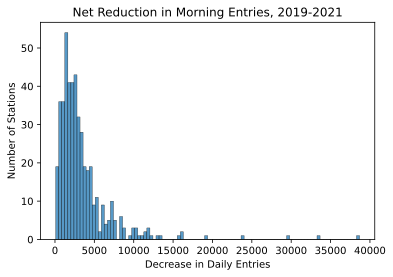

In [280]:
sns.histplot(data=dfmerged, x="DELTAENTRIES", bins=100)
plt.xlabel('Decrease in Daily Entries')
plt.ylabel('Number of Stations');
plt.title('Net Reduction in Morning Entries, 2019-2021');
plt.savefig('fig1',bbox_inches="tight")

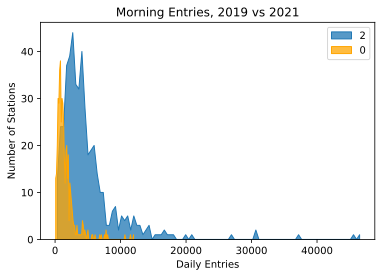

In [281]:
# plt.hist(x=dfmerged.NETENTRIES19,bins=100,range=[0,19000]);
# plt.hist(x=dfmerged.NETENTRIES21,bins=100, color='red',range=[0,19000]);
# plt.hist()
hue_order = ["NETENTRIES19","NETENTRIES21"]
sns.histplot(data=dfmerged, x="NETENTRIES19", bins=100, element='poly')
plt.legend('2019')
sns.histplot(data=dfmerged, x="NETENTRIES21", bins=100, element='poly', color='orange')
plt.legend('2021')

plt.xlabel('Daily Entries')
plt.ylabel('Number of Stations');
plt.title('Morning Entries, 2019 vs 2021');
plt.savefig('fig2',bbox_inches="tight")

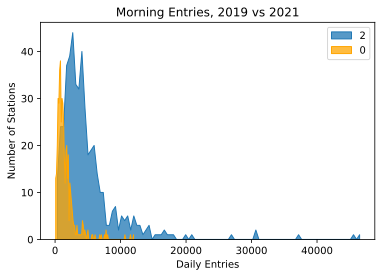

In [281]:
# plt.hist(x=dfmerged.NETENTRIES19,bins=100,range=[0,19000]);
# plt.hist(x=dfmerged.NETENTRIES21,bins=100, color='red',range=[0,19000]);
# plt.hist()

fig, ax = sns.histplot(data=dfmerged, x="NETENTRIES19", bins=100, element='poly')
plt.legend('2019')
sns.histplot(data=dfmerged, x="NETENTRIES21", bins=100, element='poly', color='orange')
plt.legend('2021')

plt.xlabel('Daily Entries')
plt.ylabel('Number of Stations');
plt.title('Morning Entries, 2019 vs 2021');
# plt.savefig('fig2',bbox_inches="tight")

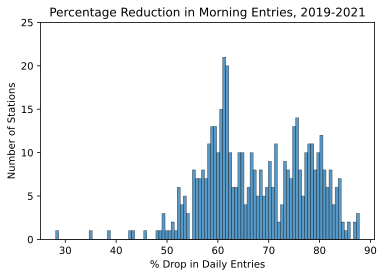

In [282]:
sns.histplot(data=dfmerged, x="PCTDROP", bins=100)
plt.xlabel('% Drop in Daily Entries')
plt.ylabel('Number of Stations');
plt.yticks(np.arange(0,26,5));
plt.title('Percentage Reduction in Morning Entries, 2019-2021');
plt.savefig('fig3',bbox_inches="tight")

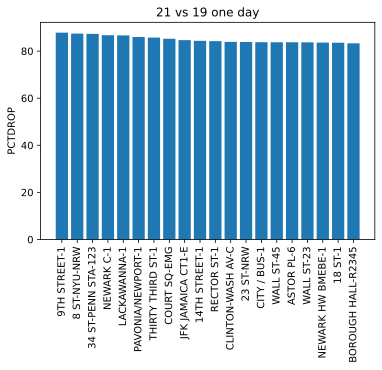

In [283]:
test = dfmerged.sort_values('PCTDROP', ascending=False)

plt.bar(x=test['STATION-LINE'][:20], height=test['PCTDROP'][:20])
plt.xticks(rotation=90);
plt.ylabel("PCTDROP");
plt.title("21 vs 19 one day");
plt.savefig('fig4',bbox_inches="tight")

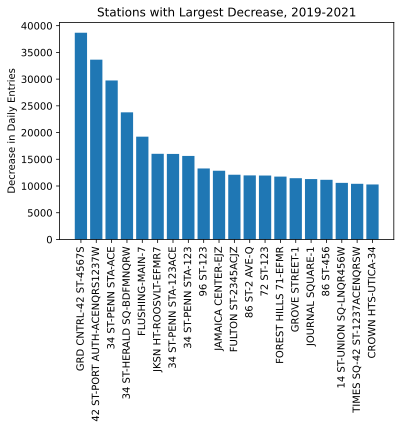

In [284]:
test = dfmerged.sort_values('DELTAENTRIES', ascending=False)
plt.bar(x=test['STATION-LINE'][:20], height=test['DELTAENTRIES'][:20])
plt.xticks(rotation=90);
plt.ylabel("Decrease in Daily Entries");
plt.title("Stations with Largest Decrease, 2019-2021");
plt.savefig('fig5',bbox_inches="tight")

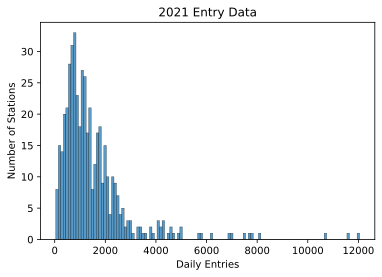

In [285]:
# plt.hist(x=dfmerged.NETENTRIES21,bins=120);

sns.histplot(data=dfmerged, x="NETENTRIES21", bins=120)
plt.xlabel('Daily Entries')
plt.ylabel('Number of Stations');
# plt.yticks(np.arange(0,26,5));
plt.title('2021 Entry Data');
plt.savefig('fig6',bbox_inches="tight")

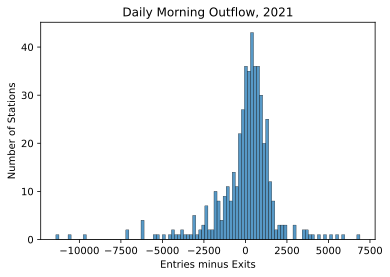

In [286]:
# plt.hist(x=dfmerged.NETENTRIES21,bins=120);

sns.histplot(data=dfmerged, x="OUTFLOW21", bins=100)
plt.xlabel('Entries minus Exits') 
plt.ylabel('Number of Stations');
# plt.yticks(np.arange(0,26,5));
plt.title('Daily Morning Outflow, 2021');
plt.savefig('fig7',bbox_inches="tight")

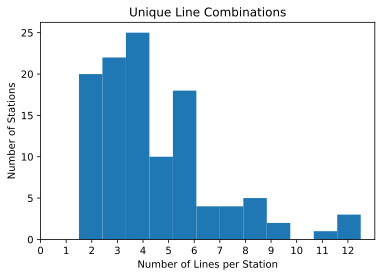

In [287]:
# dfmerged.groupby('LINENAME21')['LINENAME21.apply(first)
x = dfmerged['LINENAME21'].unique()
y = [len(item)+0.5 for item in x]
plt.hist(y,12)
plt.xticks(np.arange(0,13,1));

plt.xlabel('Number of Lines per Station')
plt.ylabel('Number of Stations');
# plt.yticks(np.arange(0,26,5));
plt.title('Unique Line Combinations');
plt.savefig('fig8',bbox_inches="tight")

### Apply masks to filter out some of the non-residential areas

In [204]:
mask_lines = (dfmerged['LINENAME21'].apply(len) < 9 )
# dfmerged[mask_lines].head(10)
mask_outflow = (dfmerged['OUTFLOW21'] >= 0 )
# dfmerged[mask_outflow].head(10)
mask_netentries = (dfmerged['NETENTRIES21'] < 4000 )
# dfmerged[mask_netentries].head(10)

dfmasked = dfmerged[(mask_lines & mask_outflow & mask_netentries)]
dfmasked.shape

(270, 15)

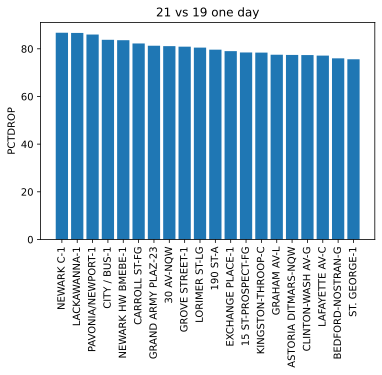

In [205]:
test = dfmasked.sort_values('PCTDROP', ascending=False)

test.head(10)

plt.bar(x=test['STATION-LINE'][:20], height=test['PCTDROP'][:20])
plt.xticks(rotation=90);
plt.ylabel("PCTDROP");
plt.title("21 vs 19 one day");


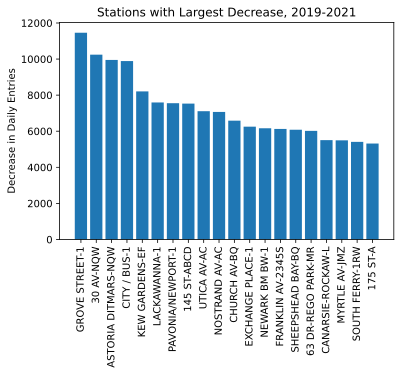

In [288]:
# test = dfmasked.sort_values('DELTAENTRIES', ascending=False)
# plt.bar(x=test['STATION-LINE'][:20], height=test['DELTAENTRIES'][:20])
# plt.xticks(rotation=90);
# plt.ylabel("DELTA ENTRIES");
# plt.title("21 vs 19 one day");

test = dfmasked.sort_values('DELTAENTRIES', ascending=False)
plt.bar(x=test['STATION-LINE'][:20], height=test['DELTAENTRIES'][:20])
plt.xticks(rotation=90);
plt.ylabel("Decrease in Daily Entries");
plt.title("Stations with Largest Decrease, 2019-2021");
plt.savefig('fig9',bbox_inches="tight")

In [217]:
test1 = dfmasked.sort_values('DELTAENTRIES', ascending=False)[0:20]
test2 = dfmasked.sort_values('PCTDROP', ascending=False)[0:20]

test3 = test1.merge(test2)
test3[['STATION-LINE','DELTAENTRIES','PCTDROP']].head(15)

,STATION-LINE,DELTAENTRIES,PCTDROP
0,GROVE STREET-1,11459.458333,80.912807
1,30 AV-NQW,10241.630556,81.122629
2,ASTORIA DITMARS-NQW,9950.841667,77.426556
3,CITY / BUS-1,9890.591667,83.792122
4,LACKAWANNA-1,7593.025000,86.680099
5,PAVONIA/NEWPORT-1,7552.917949,85.987710
6,EXCHANGE PLACE-1,6253.986111,79.029581


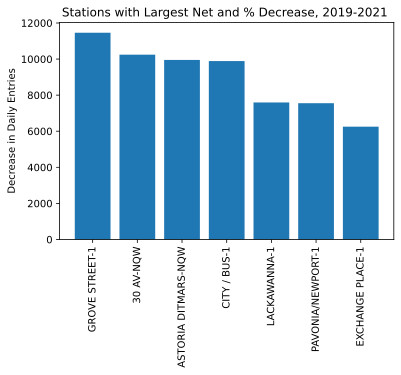

In [289]:
plt.bar(x=test3['STATION-LINE'][:20], height=test3['DELTAENTRIES'][:20])
plt.xticks(rotation=90);
plt.ylabel("Decrease in Daily Entries");
plt.title("Stations with Largest Net and % Decrease, 2019-2021 ")
plt.savefig('fig10',bbox_inches="tight")

### Seven stations in Top 20 of both DELTAENTRIES and  PCTDROP:

- GROVE STREET - Greenwich Village (Manhattan) - PATH-1 Line  
- 30 AV   -  Astoria (Queens)  - NQW Line  
- ASTORIA DITMARS  - Astoria (Queens)  - NQW Line  
- CITY / BUS  - Somewhere in NJ   - PATH-1 Line  
- LACKAWANNA   - Hoboken (NJ) - PATH-1 Line  
- PAVONIA/NEWPORT  - Jersey City (NJ)  - PATH-1 Line  
- EXCHANGE PLACE   -  Jersey City (NJ)  - PATH-1 Line  